importing Jupyter notebook from organizing.ipynb
importing Jupyter notebook from loadMSIS.ipynb
ModelWeb Browser Results
msis model listing
Input parameters
year= 2005, month= 12, day= 12, hour=19.,
latitude= 69.59, longitude= 20., height= 100.
Prof. parameters: start= 80. stop= 700. step= 5.

 F10.7(daily) used:  90.2
 F10.7(3-month avg) used:  84.3
 ap(daily,0-3,3-6,6-9,9-12,12-33,33-59 h prior) used:
    12.1    15.0  15.0   7.0   5.0  20.6  11.3


                NUMBER DENSITIES          MASS DENSITY  TEMPERATURE
    H/KM     O/cm-3    N2/cm-3    O2/cm-3   m/g*cm-3     TN/K TEXO/K
    80.0   2.673E+09  1.818E+14  4.847E+13  1.117E-08   216.6  1037
    85.0   3.296E+10  8.566E+13  2.269E+13  5.255E-09   210.7  1037
    90.0   1.476E+11  3.966E+13  1.038E+13  2.430E-09   204.1  1037
    95.0   2.908E+11  1.790E+13  4.572E+12  1.096E-09   197.8  1037
   100.0   3.239E+11  7.724E+12  1.887E+12  4.732E-10   197.8  1037
   105.0   2.575E+11  3.221E+12  7.307E+11  1.974E-10   210.6  1037

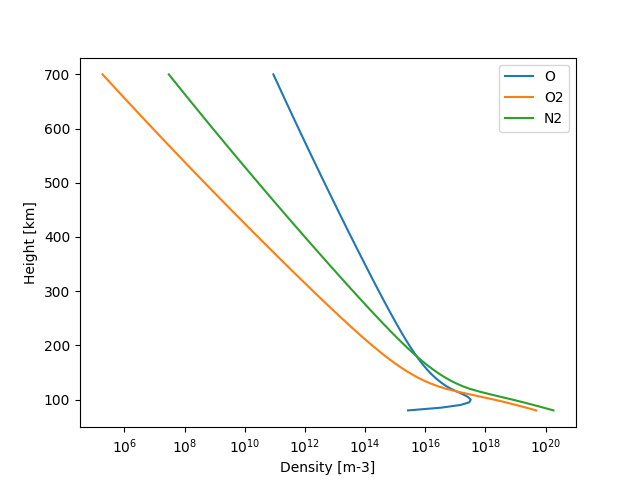

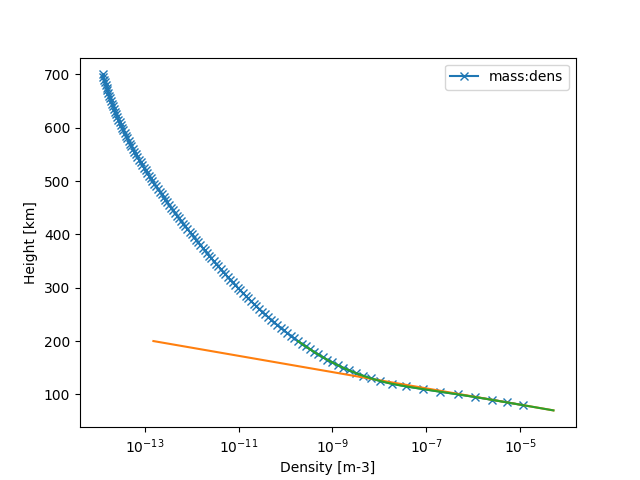

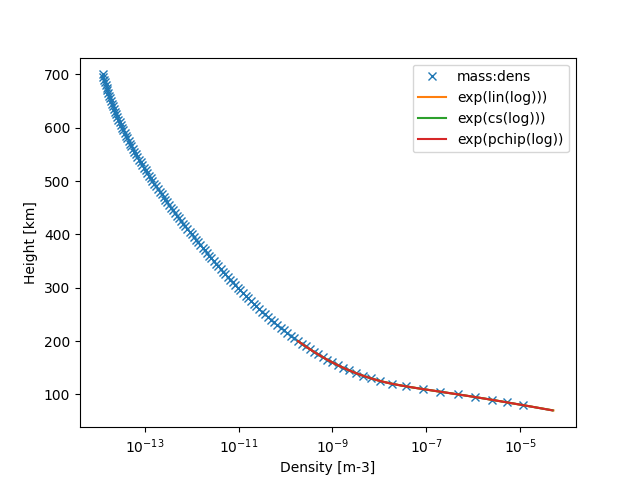

In [1]:
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
%matplotlib widget

import organizing
import loadMSIS
import loadIRI
import EnergyDissipation 
import loadEISCAT
import AuroralPrecipitation as ap

from labellines import labelLine, labelLines
from scipy.integrate import solve_ivp



'''
This is the main file. It is used to start the simulation.
Configuration files from IRI and MSIS models are specified here.
Eiscat data files are specified here.
'''

#configuring printing option
con = organizing.pcfg
con.disable()
print('Printing: ', con.print)

#defining file paths
msis_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'
iri_config  = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'
path_eiscat_data = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Data/'

#setup log directory
setup_ = organizing.setup(msis_config, iri_config, chemistry_config, path_eiscat_data)
log_directory = setup_._log_directory

#load neutroal atmopshere model
[z_msis
 , n_o1_msis
 , n_n2_msis
 , n_o2_msis
 , mass_density
 , temp_n_msis
 , scale_height_msis] = loadMSIS.loadMSIS(log_directory + '/Config/msis.txt')

#load ionosphere model
[z_iri     
 , ne_iri    
 , t_neutral 
 , t_ion     
 , t_e       
 , rel_o_p   
 , rel_n_p   
 , rel_h_p   
 , rel_he_p  
 , rel_o2_p  
 , rel_no_p] = loadIRI.loadIRI(log_directory + '/Config/iri.txt')

#replace all negative temperatures (-1 K) in IRI model by MSIS model (up to 115 km height, where Te = Ti = Tn)
t_e[t_e<0]             = temp_n_msis[t_e<0]
t_ion[t_ion<0]         = temp_n_msis[t_ion<0]
t_neutral[t_neutral<0] = temp_n_msis[t_neutral<0]

In [2]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)
e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2

#defining parameters for electron production model
inc_B = 0
z_min = 80000
z_max = 207400
res_model = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

#electron production model
e_prod, z_model = EnergyDissipation.e_production(z_min
                                                 , z_max
                                                 , res_model
                                                 , z_sd_min
                                                 , z_sd_max
                                                 , res_sd
                                                 , e_bin_lims
                                                 , z_msis
                                                 , mass_density
                                                 , inc_B)


0.0


In [3]:
#load EISCAT data
[z_radar_time
 , parameters
 , time
 , az
 , el
 , r_errors ] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_h', 'r_param', 'r_time', 'r_az', 'r_el', 'r_error'])

z_radar = z_radar_time[0] #for static measurements, the information in r_h stays the same for all measurement points.
ne_meas = parameters[:, :, 0]
dne_meas = r_errors[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]


#conversion to SI units:
z_radar = z_radar*1e3
r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]

zr_diff = (z_radar[1:]- z_radar[:-1])/2
zr_lim = np.array([*z_radar, z_radar[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])
del zr_diff, parameters, r_errors, z_radar_time, az, el, time


#reducing radar measurements to heights specified:
if con.print: 
    filt = z_radar <= z_max
    print(filt)
    print(z_radar[filt])
    print(z_radar[z_radar <= z_max].shape)
    print(z_radar.shape)
    print(ne_meas.shape)
    print(ne_meas[:, filt].shape)
    print(dne_meas.shape)
    print(vel.shape)
    print(vel_err.shape)

filt = z_radar <= z_max

z_radar = z_radar[filt]
ne_meas = ne_meas[:, filt]
dne_meas = dne_meas[:, filt]
vel = vel[:, filt]
vel_err = vel_err[:, filt]

In [4]:
#setup of ion chemistry
import ionChem

model = ionChem.ionChem(chemistry_config, z_model)

model.assign_densities(z_model
                     , z_msis
                     , n_o1_msis
                     , n_n2_msis
                     , n_o2_msis
                     , z_iri
                     , ne_iri        
                     , rel_o_p   
                     , rel_n_p   
                     , rel_h_p   
                     , rel_he_p  
                     , rel_o2_p  
                     , rel_no_p)

#check for self-consistency
model.check_chargeNeutrality()

model.assign_temperatures(z_iri
                          , t_neutral 
                          , t_ion     
                          , t_e)

#saving the initial state
setup_.datadump(model)



importing Jupyter notebook from ionChem.ipynb


<string>:212: RuntimeWarning: divide by zero encountered in log


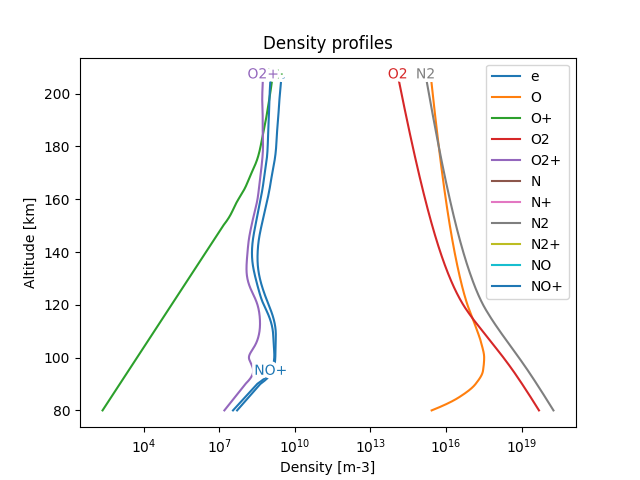

In [5]:
model.plot_density()
#plt.xscale('linear')

In [6]:
if con.print:
    plt.figure()
    for j in range(np.int_(e_prod.shape[1]/100)):
        i = j * 100
        plt.plot(e_prod_ps[:, i], z_model/1e3, label = 'smeared', ls = '--')
        plt.plot(e_prod[:, i], z_model/1e3, label = '%.2f keV' % (e_bin_mean[i]/1e3))    
        plt.legend()
        plt.xscale('log')
        plt.xlabel('Production rate [m^3s^-1]')
        plt.ylabel('Altitude [km]')

In [7]:
if con.print:
    plt.figure()
    ne_int = np.zeros(len(z_radar))
    for i in range(len(z_radar)):
        ne_int[i] = ap.ne_height_int(z_model, model.e.density, zr_lim[i], zr_lim[i+1])
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Interpolation of e for height integration')
    plt.legend()
    #plt.ylim(70, 200)   

In [8]:
if con.print:
    plt.figure()
    plt.plot(model.e.density, z_model/1e3, label = 'high res2')
    plt.plot(ne_int, z_radar/1e3, 'x', label = 'radar res')
    plt.legend()
    plt.xscale('log')
    plt.ylim(70, 200)
    plt.title('Simulated radar measurements of ne')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')

In [9]:
#first estimate of electron density, directly assigned to model.el.density (ion model needs to be initiatiated first!)
#using polynomial of 3rd order

#prepping:
e_prod_ps = ap.pulse_smearing_4_e_prod(e_prod, pulse_height = 2000, res = res_model)

eff_recombinationRate = (model.alpha1.r_rate()*model.NOp.density/model.e.density + \
                         model.alpha2.r_rate()*model.O2p.density/model.e.density)

param = [ 1.86421376e+01, -5.16833339e-01,  4.15756160e-03, -8.02510832e-5]

def sumofsq_ne0(par4diff_flux, e_bin_mean, ne_obs, dne_obs, e_prod, eff_recombinationRate):
    diff_flux = ap.diff_flux_kev(e_bin_mean, par4diff_flux)
    ne_mod    = np.sqrt(np.dot(e_prod, diff_flux)/eff_recombinationRate)
    ne_mod_r  = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
    sumofsq   = np.sum((ne_obs - ne_mod_r)**2/dne_obs**2)
    return sumofsq

#minimize
from scipy.optimize import minimize
result_t0 = minimize(sumofsq_ne0, 
                     param,
                     method = 'Nelder-Mead',
                     bounds = [(None, None),(None, None),(-np.inf, np.inf),(-np.inf, 0)], 
                     args=(e_bin_mean, ne_meas[0], dne_meas[0], e_prod, eff_recombinationRate)
                     )


print(result_t0.x)
ne_prod0 = np.dot(e_prod, ap.diff_flux_kev(e_bin_mean, result_t0.x))
ne_mod0  = np.sqrt(ne_prod0/eff_recombinationRate)

if any(ne_prod0 < 0): raise RuntimeError('Negative production')
if any(ne_mod0  < 0): raise RuntimeError('Negative Electron Density')

ne_mod0_radar = np.array([ap.ne_height_int(z_model, ne_mod0, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
red_chi2 = np.sum((ne_meas[0] -  ne_mod0_radar)**2 / dne_meas[0]**2) / (len(z_radar) - len(result_t0.x))
print(red_chi2)

[ 1.93101286e+01 -3.13048730e+00  3.59420546e-01 -1.35826894e-02]
9.088262274687128


(1274,)
(1274,)
0.0


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_81410/2053077622.py:27: RuntimeWarning: divide by zero encountered in log
  print(np.exp(np.log(0)))


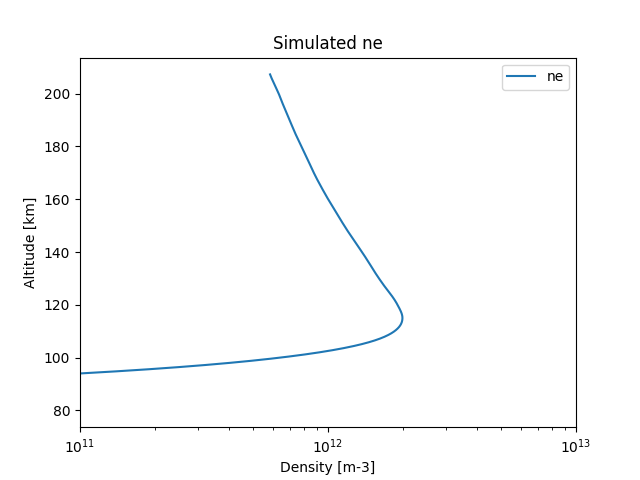

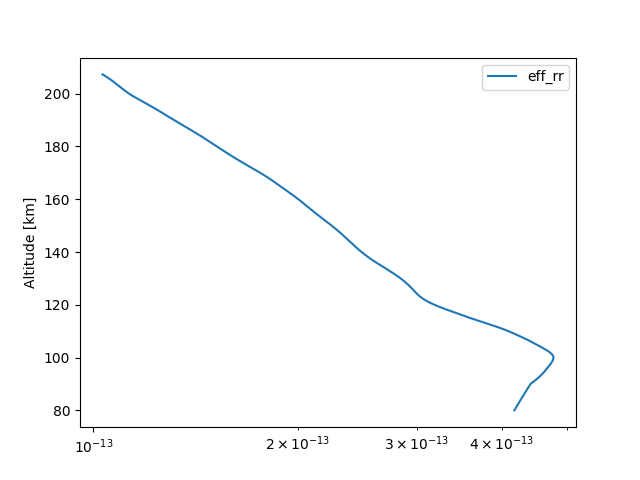

In [10]:
con.enable()
if con.print:
    param = [ 1.86421376e+01, -5.16833339e-01,  4.15756160e-03, -8.02510832e-5]
    diff_flux = ap.diff_flux_kev(e_bin_mean, param)
    ne_mod    = np.sqrt(np.dot(e_prod, diff_flux)/eff_recombinationRate)
    ne_mod_r  = np.array([ap.ne_height_int(z_model, ne_mod, zr_lim[i], zr_lim[i+1]) for i in range(len(z_radar))])
    
    plt.figure()
    plt.plot(ne_mod, z_model/1e3, label = 'ne')
    plt.legend()
    plt.xscale('log')
    plt.title('Simulated ne')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.xlim(1e11, 1e13)
    
    plt.figure()
    plt.plot(eff_recombinationRate, z_model/1e3, label = 'eff_rr')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('')
    plt.ylabel('Altitude [km]')
    #plt.xlim(1e11, 1e13)
    
    print(ne_mod.shape)
    print(ne_mod[ne_mod > 0].shape)
    print(np.exp(np.log(0)))

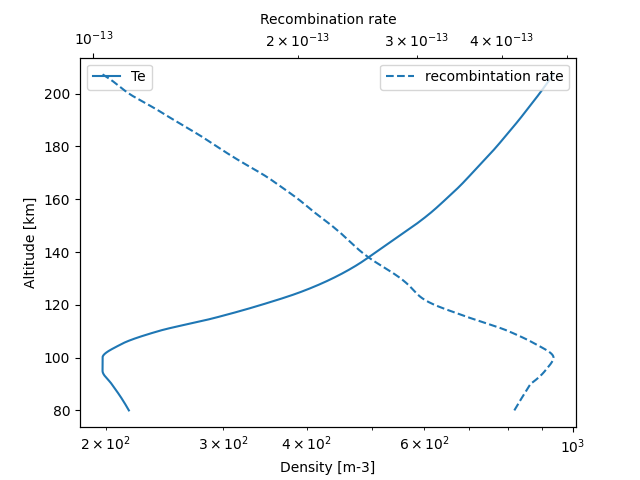

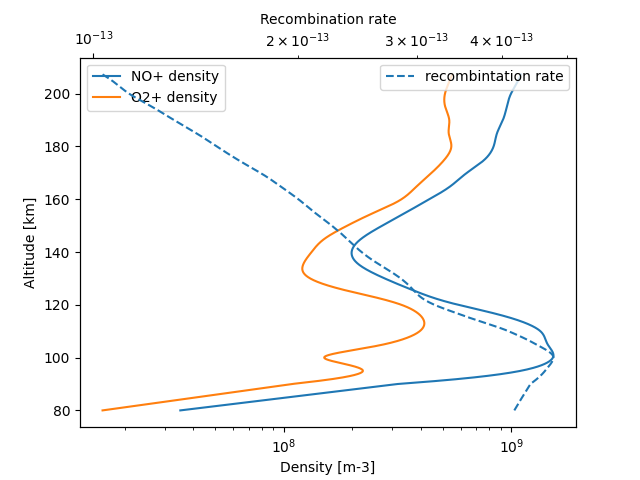

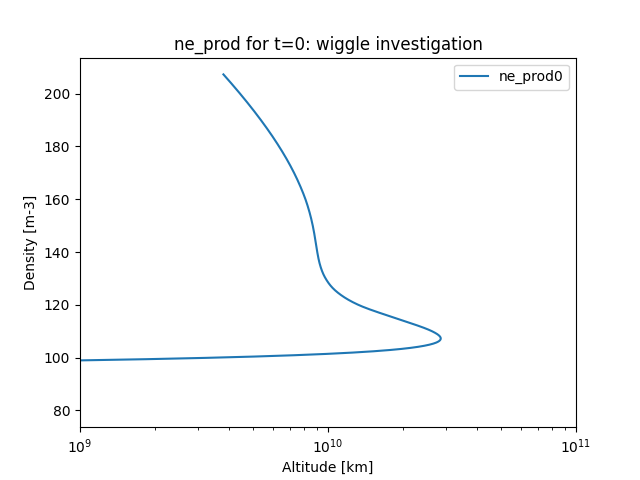

In [11]:
if con.print:
    plt.figure()
    plt.plot(model.Te, z_model/1e3, label = 'Te')
    #plt.plot(model.O2p.density, z_model/1e3, label = 'O2+ density')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    ax2 = plt.gca().twiny()
    ax2.plot(eff_recombinationRate, z_model/1e3, '--', label = 'recombintation rate')
    plt.xlabel('Recombination rate')
    plt.xscale('log')
    plt.legend()

    
    plt.figure()
    plt.plot(model.NOp.density, z_model/1e3, label = 'NO+ density')
    plt.plot(model.O2p.density, z_model/1e3, label = 'O2+ density')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    ax2 = plt.gca().twiny()
    ax2.plot(eff_recombinationRate, z_model/1e3, '--', label = 'recombintation rate')
    plt.xlabel('Recombination rate')
    plt.xscale('log')
    plt.legend()

    
    plt.figure()
    plt.plot(ne_prod0, z_model/1e3, label = 'ne_prod0')
    plt.ylabel('Density [m-3]')
    plt.xlabel('Altitude [km]')
    plt.xscale('log')
    plt.xlim(1e9, 1e11)
    plt.title('ne_prod for t=0: wiggle investigation')
    plt.legend()
    

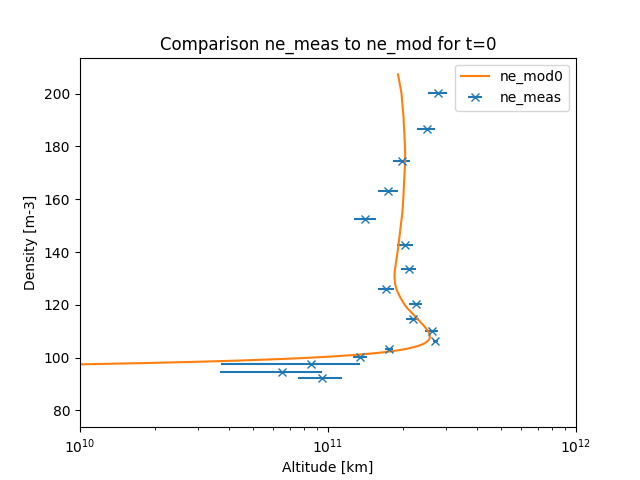

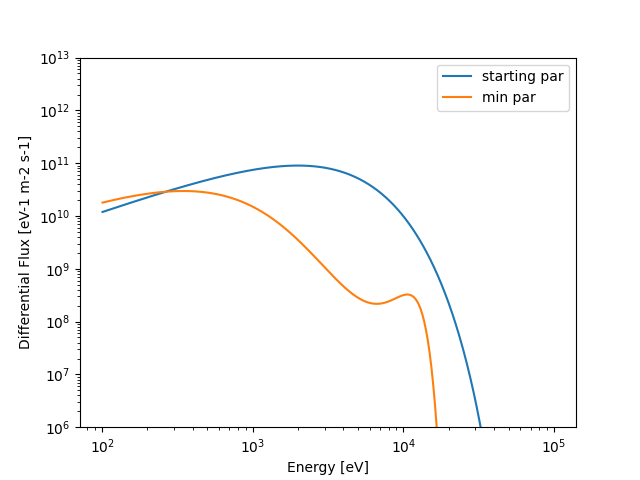

In [12]:
con.enable()
if con.print:
    plt.figure()
    plt.errorbar(ne_meas[0], z_radar/1e3, xerr = dne_meas[0], marker = 'x', linestyle = ' ', label = 'ne_meas')
    plt.plot(ne_mod0, z_model/1e3, label = 'ne_mod0')
    plt.ylabel('Density [m-3]')
    plt.xlabel('Altitude [km]')
    plt.xscale('log')
    plt.xlim(1e10, 1e12)
    plt.title('Comparison ne_meas to ne_mod for t=0')
    plt.legend()
    
    plt.figure()
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, param), label = 'starting par')
    plt.plot(e_bin_mean, ap.diff_flux_kev(e_bin_mean, result_t0.x), label = 'min par')
    plt.ylabel('Differential Flux [eV-1 m-2 s-1]')
    plt.xlabel('Energy [eV]')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e6, 1e13)
    plt.legend()
con.disable()

In [13]:
#check for self-consistency
model.check_chargeNeutrality()
#saving the initial state
setup_.datadump(model)

In [14]:
#do some testing with ion chemistry, eg only recombinative processes and see how it evovles
#why do i have problmes with charge neutrality for larger timesteps?

In [15]:
#calculate decay times to find species and altitudes where prod / loss is nearly instantaneous.
#not used at the moment
eff_rr = np.zeros([len(model.all_species), model.n_heights])

for c in model.all_species:
    rr_species = np.zeros([len(model.all_species), model.n_heights], dtype = 'float64')
    
    for r in model.all_reactions:
        if c.c_ID in r.educts_ID:
            #if con.print(): print(r.r_stoch, '\n', c.name, *r.educts[r.educts != c.name], '\n', c.c_ID, *r.educts_ID[r.educts_ID != c.c_ID], '\n')
            [cid2] = r.educts_ID[r.educts_ID != c.c_ID]
            rr_species[cid2] = r.r_rate()*model.all_species[cid2].density
                
    eff_rr[c.c_ID, :] = np.sum(rr_species, axis = 0)

    
filter_ = eff_rr[:, :] > 1 
sum_rows = np.sum(filter_, axis = 0) #number of "instantaneaous" DE per height bin


<string>:451: RuntimeWarning: divide by zero encountered in divide
<string>:451: RuntimeWarning: divide by zero encountered in divide
<string>:451: RuntimeWarning: divide by zero encountered in divide
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


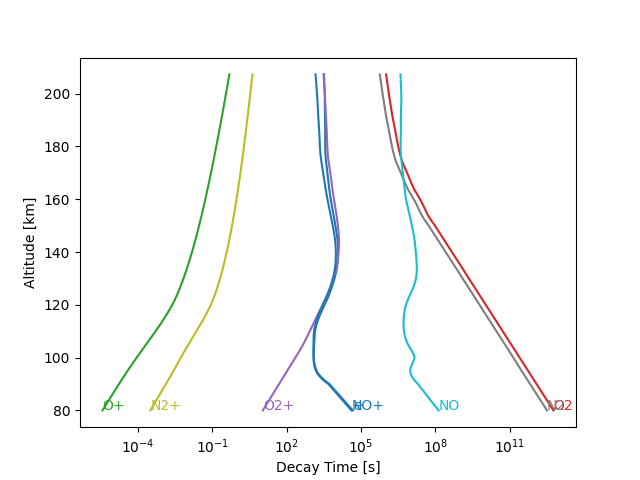

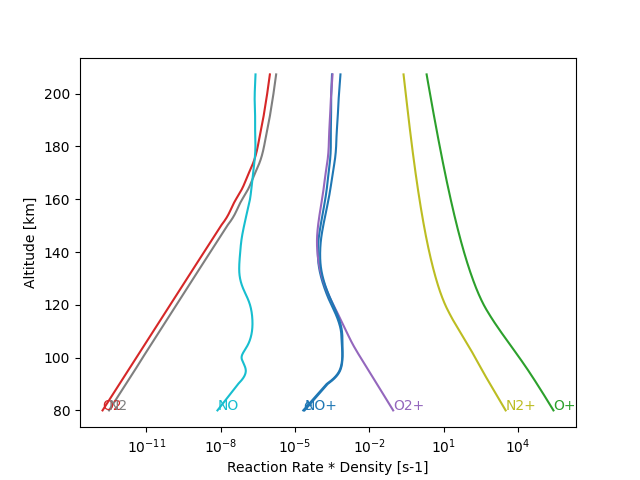

In [16]:
con.enable()
model.plot_decayTime()
model.plot_reactionRate()

In [17]:
#to do: check definition of Tr
#cubic_spline in assign density: check if correctly interpolated!!!


In [18]:
con.disable()
if con.print:
    plt.figure()
    plt.plot(t_neutral, z_iri/1e3, 'x')
    plt.plot(t_ion[10:], z_iri[10:]/1e3, 'x')
    plt.plot(t_e, z_iri/1e3, 'x')

In [19]:
def fun(t, n, h):
    ode = np.zeros(n.shape)
    
    for c in model.all_species:
        i = c.c_ID
        loss_rr  = np.array(model.loss_table_rr[:, i, h])
        loss_IDs = np.array(model.loss_table_ind[:, i], dtype = int)
        
        prod_rr   = np.array(model.prod_table_rr[:, i, h])
        prod_IDs1 = np.array(model.prod_table_ind[:, i, 1], dtype = int)
        prod_IDs2 = np.array(model.prod_table_ind[:, i, 0], dtype = int)
        
        #loss, prod:
        ode[i] = -np.sum(loss_rr * n[loss_IDs], axis = 0) * n[i] \
                 +np.sum(prod_rr * n[prod_IDs1] * n[prod_IDs2], axis = 0) \
                # +aurural_prod[i] \
                # +uv_prod[i]
    return ode

#update reaction rates with new temperatures:
model.prodTable()
model.lossTable()

for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res = solve_ivp(fun, (0, 0.1), n, method='Radau',vectorized=False, args = [h])
    for j, c in enumerate(model.all_species):
        c.density[h] = res.y[j, -1]

model.check_chargeNeutrality()
setup_.datadump(model)


In [20]:
z_model/1e3

array([ 80. ,  80.1,  80.2, ..., 207.1, 207.2, 207.3])

In [21]:
z_radar/1e3

array([ 92.37490561,  94.61486954,  97.63323137, 100.27904824,
       103.27907699, 106.47576389, 110.02489185, 114.73153728,
       120.23063234, 126.00405717, 133.71651132, 142.80102397,
       152.37173813, 163.044024  , 174.37207796, 186.6852375 ,
       200.17443372])

In [22]:
z_iri/1e3

array([ 80.,  85.,  90.,  95., 100., 105., 110., 115., 120., 125., 130.,
       135., 140., 145., 150., 155., 160., 165., 170., 175., 180., 185.,
       190., 195., 200., 205., 210., 215., 220., 225., 230., 235., 240.,
       245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
       300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350.,
       355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
       410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460.,
       465., 470., 475., 480., 485., 490., 495., 500., 505., 510., 515.,
       520., 525., 530., 535., 540., 545., 550., 555., 560., 565., 570.,
       575., 580., 585., 590., 595., 600., 605., 610., 615., 620., 625.,
       630., 635., 640., 645., 650., 655., 660., 665., 670., 675., 680.,
       685., 690., 695., 700.])

In [23]:
z_msis/1e3

array([ 80.,  85.,  90.,  95., 100., 105., 110., 115., 120., 125., 130.,
       135., 140., 145., 150., 155., 160., 165., 170., 175., 180., 185.,
       190., 195., 200., 205., 210., 215., 220., 225., 230., 235., 240.,
       245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
       300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350.,
       355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
       410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460.,
       465., 470., 475., 480., 485., 490., 495., 500., 505., 510., 515.,
       520., 525., 530., 535., 540., 545., 550., 555., 560., 565., 570.,
       575., 580., 585., 590., 595., 600., 605., 610., 615., 620., 625.,
       630., 635., 640., 645., 650., 655., 660., 665., 670., 675., 680.,
       685., 690., 695., 700.])

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

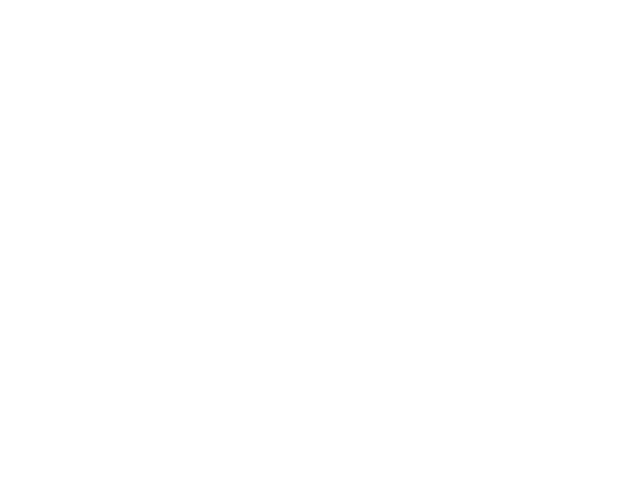

In [24]:
plt.figure()
plt.plot